In [1]:
import sys

sys.path.insert(0, "..")

import time
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
)

# Our modules
from src.agents.ppo_agent import PPOAgent
from src.environment.gym_env import InventoryEnvironment
from src.mdp import RewardFunction
from src.agents.callbacks.learning_curve_callback import LearningCurveCallback
from src.agents.metrics import TrainingMetrics, EvaluationMetrics
from src.seeds import generate_seeds

# Plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)

print("✅ All imports successful!")

# Initialize plot classes

training_plots = TrainingMetrics()
evaluation_plots = EvaluationMetrics()

✅ All imports successful!


## 1. Configuration

Set up seeds and basic configuration for Optuna hyperparameter search.

In [2]:
# Seeds for reproducibility
TRAINING_SEED = generate_seeds(1, start_index=20)[0]
EVAL_SEEDS = generate_seeds(50, start_index=100)  # Use 50 for faster evaluation

# Training budget per trial
TRAINING_TIMESTEPS = 1_000_000  # 1M per trial for faster iteration

print(f"🎲 Seeds:")
print(f"   Training: {TRAINING_SEED}")
print(f"   Evaluation: {len(EVAL_SEEDS)} seeds starting at {EVAL_SEEDS[0]}")
print(f"\n⏱️  Training budget: {TRAINING_TIMESTEPS:,} timesteps per trial")

🎲 Seeds:
   Training: 6173
   Evaluation: 50 seeds starting at 2216

⏱️  Training budget: 1,000,000 timesteps per trial


## 2. Optuna Objective Function

Define the objective function that Optuna will optimize. This function:
1. Samples hyperparameters using Optuna's trial object
2. Creates and trains a PPO agent
3. Evaluates the agent
4. Returns the mean episode cost (to minimize)

In [3]:
def objective(trial: optuna.Trial) -> float:
    """
    Objective function for Optuna optimization.
    Returns mean episode cost (to minimize).
    """
    
    # ========================================================================
    # SAMPLE HYPERPARAMETERS
    # ========================================================================
    
    # Environment parameters
    k = trial.suggest_int("k", 15, 32, step=5)
    Q_max = trial.suggest_int("Q_max", 25, 40, step=5)
    
    # Core PPO hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float("gamma", 0.95, 0.999)
    n_steps = trial.suggest_categorical("n_steps", [1024, 2048, 4096])
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    n_epochs = trial.suggest_int("n_epochs", 5, 20)
    clip_range = trial.suggest_float("clip_range", 0.1, 0.3)
    ent_coef = trial.suggest_float("ent_coef", 0.0, 0.1)
    gae_lambda = trial.suggest_float("gae_lambda", 0.9, 0.98)
    
    # Network architecture
    net_arch_choice = trial.suggest_categorical("net_arch", ["256x256", "512x512"])
    net_arch = [256, 256] if net_arch_choice == "256x256" else [512, 512]
    
    print(f"\n{'='*80}")
    print(f"Trial {trial.number}")
    print(f"{'='*80}")
    print(f"Environment: k={k}, Q_max={Q_max}")
    print(f"Agent: lr={learning_rate:.2e}, γ={gamma:.3f}, steps={n_steps}, batch={batch_size}")
    print(f"       epochs={n_epochs}, clip={clip_range:.2f}, ent={ent_coef:.3f}, gae={gae_lambda:.2f}")
    print(f"       net_arch={net_arch}")
    
    # ========================================================================
    # TRAIN AGENT
    # ========================================================================
    
    try:
        # Create environment
        env = InventoryEnvironment(
            k=k,
            Q_max=Q_max,
            episode_length=1000,
            random_seed=TRAINING_SEED,
        )
        
        # Create agent
        agent = PPOAgent(
            env=env,
            learning_rate=learning_rate,
            gamma=gamma,
            n_steps=n_steps,
            batch_size=batch_size,
            n_epochs=n_epochs,
            clip_range=clip_range,
            ent_coef=ent_coef,
            gae_lambda=gae_lambda,
            policy_kwargs=dict(net_arch=net_arch),
            seed=TRAINING_SEED,
            verbose=0,
        )
        
        # Train
        print(f"\n⏳ Training for {TRAINING_TIMESTEPS:,} timesteps...")
        start_time = time.time()
        
        learning_curve_callback = LearningCurveCallback()
        agent.train(
            total_timesteps=TRAINING_TIMESTEPS,
            progress_bar=False,
            callbacks=learning_curve_callback,
        )
        
        training_time = time.time() - start_time
        print(f"✅ Training complete in {training_time/60:.1f} minutes")
        
        # ========================================================================
        # EVALUATE AGENT
        # ========================================================================
        
        print(f"🧪 Evaluating on {len(EVAL_SEEDS)} episodes...")
        episode_costs = []
        
        for seed in EVAL_SEEDS:
            eval_env = InventoryEnvironment(
                k=k,
                Q_max=Q_max,
                episode_length=1000,
                random_seed=seed,
            )
            
            obs, _ = eval_env.reset()
            total_cost = 0.0
            done = False
            
            while not done:
                action = agent.select_action(obs, deterministic=True)
                obs, reward, terminated, truncated, _ = eval_env.step(action)
                total_cost += -reward  # Convert reward to cost
                done = terminated or truncated
            
            episode_costs.append(total_cost)
        
        mean_cost = float(np.mean(episode_costs))
        std_cost = float(np.std(episode_costs))
        
        print(f"✅ Mean episode cost: ${mean_cost:.2f} ± ${std_cost:.2f}")
        
        # Report intermediate values for pruning
        trial.report(mean_cost, step=0)
        
        # Save trial info
        trial.set_user_attr("training_time", training_time)
        trial.set_user_attr("std_cost", std_cost)
        trial.set_user_attr("final_training_reward", learning_curve_callback.episode_rewards[-1])
        
        return mean_cost
        
    except Exception as e:
        print(f"❌ Trial failed with error: {e}")
        raise optuna.TrialPruned()

print("✅ Objective function defined")

✅ Objective function defined


## 3. Create Optuna Study

Configure and create the Optuna study for hyperparameter optimization.

In [4]:
# Create Optuna study
study = optuna.create_study(
    study_name="ppo_inventory_optimization",
    direction="minimize",  # Minimize mean episode cost
    sampler=optuna.samplers.TPESampler(seed=TRAINING_SEED),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=0),
)

print("✅ Optuna study created")
print(f"   Study name: {study.study_name}")
print(f"   Direction: {study.direction}")
print(f"   Sampler: {study.sampler.__class__.__name__}")
print(f"   Pruner: {study.pruner.__class__.__name__}")

[I 2026-01-10 20:33:37,315] A new study created in memory with name: ppo_inventory_optimization


✅ Optuna study created
   Study name: ppo_inventory_optimization
   Direction: 1
   Sampler: TPESampler
   Pruner: MedianPruner


## 4. Run Optimization

Run Optuna optimization with the specified number of trials.
Optuna will intelligently explore the hyperparameter space using Tree-structured Parzen Estimator (TPE).

In [5]:
# Number of trials to run
N_TRIALS = 30  # Adjust based on compute budget

print(f"🚀 Starting Optuna optimization with {N_TRIALS} trials")
print(f"   Estimated time: ~{N_TRIALS * 15:.0f} minutes (15 min per trial)")
print(f"{'='*80}\n")

# Run optimization
study.optimize(
    objective,
    n_trials=N_TRIALS,
    show_progress_bar=True,
)

print(f"\n{'='*80}")
print(f"🎉 OPTIMIZATION COMPLETE!")
print(f"{'='*80}")

🚀 Starting Optuna optimization with 30 trials
   Estimated time: ~450 minutes (15 min per trial)



  0%|          | 0/30 [00:00<?, ?it/s]


Trial 0
Environment: k=25, Q_max=25
Agent: lr=5.26e-04, γ=0.980, steps=2048, batch=256
       epochs=20, clip=0.20, ent=0.097, gae=0.98
       net_arch=[512, 512]


/Users/marin/Documents/UNIMORE_4^anno/RL-InventorySystem/.venv/lib/python3.12/site-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [15, 32] and step=5, but the range is not divisible by `step`. It will be replaced with [15, 30].
  warnings.warn(



⏳ Training for 1,000,000 timesteps...
✅ Training complete in 17.2 minutes
🧪 Evaluating on 50 episodes...
✅ Mean episode cost: $12563931.26 ± $591769.24
[I 2026-01-10 20:50:57,079] Trial 0 finished with value: 12563931.26 and parameters: {'k': 25, 'Q_max': 25, 'learning_rate': 0.0005255571762837691, 'gamma': 0.9796069366908455, 'n_steps': 2048, 'batch_size': 256, 'n_epochs': 20, 'clip_range': 0.19515105794523083, 'ent_coef': 0.09704873693501509, 'gae_lambda': 0.9769782365800579, 'net_arch': '512x512'}. Best is trial 0 with value: 12563931.26.

Trial 1
Environment: k=25, Q_max=25
Agent: lr=3.74e-05, γ=0.982, steps=1024, batch=256
       epochs=9, clip=0.21, ent=0.070, gae=0.91
       net_arch=[512, 512]

⏳ Training for 1,000,000 timesteps...


/Users/marin/Documents/UNIMORE_4^anno/RL-InventorySystem/.venv/lib/python3.12/site-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [15, 32] and step=5, but the range is not divisible by `step`. It will be replaced with [15, 30].
  warnings.warn(


✅ Training complete in 10.0 minutes
🧪 Evaluating on 50 episodes...
✅ Mean episode cost: $11417798.44 ± $343900.15
[I 2026-01-10 21:01:08,840] Trial 1 finished with value: 11417798.44 and parameters: {'k': 25, 'Q_max': 25, 'learning_rate': 3.738479668521229e-05, 'gamma': 0.9820410873184745, 'n_steps': 1024, 'batch_size': 256, 'n_epochs': 9, 'clip_range': 0.20826392869378793, 'ent_coef': 0.07048986631507058, 'gae_lambda': 0.9140841516143294, 'net_arch': '512x512'}. Best is trial 1 with value: 11417798.44.

Trial 2
Environment: k=20, Q_max=25
Agent: lr=2.26e-05, γ=0.953, steps=1024, batch=64
       epochs=9, clip=0.24, ent=0.013, gae=0.97
       net_arch=[512, 512]

⏳ Training for 1,000,000 timesteps...
✅ Training complete in 18.7 minutes
🧪 Evaluating on 50 episodes...
✅ Mean episode cost: $12464576.38 ± $486907.79
[I 2026-01-10 21:20:02,227] Trial 2 finished with value: 12464576.38 and parameters: {'k': 20, 'Q_max': 25, 'learning_rate': 2.2644733686562685e-05, 'gamma': 0.9529037918932077

## 5. Optimization Results

Analyze the optimization results and identify the best hyperparameters.

In [6]:
# Get best trial
best_trial = study.best_trial

print("🏆 BEST TRIAL RESULTS")
print("=" * 80)
print(f"Trial number: {best_trial.number}")
print(f"Mean episode cost: ${best_trial.value:.2f}")
print(f"Std cost: ${best_trial.user_attrs['std_cost']:.2f}")
print(f"Training time: {best_trial.user_attrs['training_time']/60:.1f} minutes")
print()

print("📋 BEST HYPERPARAMETERS:")
print("=" * 80)
for key, value in best_trial.params.items():
    print(f"   {key}: {value}")
print()

# Save best configuration
best_config = {
    "trial_number": best_trial.number,
    "mean_cost": best_trial.value,
    "std_cost": best_trial.user_attrs['std_cost'],
    "training_time": best_trial.user_attrs['training_time'],
    "hyperparameters": best_trial.params,
}

config_path = "./models/config_ppo_best_optuna.json"
Path(config_path).parent.mkdir(parents=True, exist_ok=True)
with open(config_path, 'w') as f:
    json.dump(best_config, f, indent=2)
print(f"💾 Best configuration saved: {config_path}")

# Create comparison DataFrame
trials_df = study.trials_dataframe()
trials_df = trials_df.sort_values("value")  # Sort by cost (ascending)
print(f"\n📊 Top 5 Trials:")
print("=" * 80)
print(trials_df[["number", "value", "params_k", "params_Q_max", "params_learning_rate", 
                 "params_n_steps", "params_gamma"]].head(10).to_string(index=False))

🏆 BEST TRIAL RESULTS
Trial number: 26
Mean episode cost: $7179549.54
Std cost: $234416.83
Training time: 12.5 minutes

📋 BEST HYPERPARAMETERS:
   k: 15
   Q_max: 30
   learning_rate: 4.7323769538090234e-05
   gamma: 0.9595638335265396
   n_steps: 1024
   batch_size: 128
   n_epochs: 15
   clip_range: 0.23985207568718664
   ent_coef: 0.0004203603366010958
   gae_lambda: 0.9352707314080113
   net_arch: 256x256

💾 Best configuration saved: ./models/config_ppo_best_optuna.json

📊 Top 5 Trials:
 number      value  params_k  params_Q_max  params_learning_rate  params_n_steps  params_gamma
     26 7179549.54        15            30              0.000047            1024      0.959564
     15 7219816.44        15            30              0.000057            1024      0.975600
      3 7241262.28        20            30              0.000252            1024      0.973560
     17 7246619.68        15            30              0.000063            1024      0.960378
     22 7423219.14        15  

## 6. Optimization Visualizations

Visualize the optimization process using Optuna's built-in plotting functions.

In [ ]:
# Optimization history
fig = plot_optimization_history(study)
fig.update_layout(
    title="Optimization History: Mean Episode Cost Over Trials",
    width=1000,
    height=500,
)
fig.show()

# Parameter importances
fig = plot_param_importances(study)
fig.update_layout(
    title="Hyperparameter Importances (FanovaImportanceEvaluator)",
    width=1000,
    height=600,
)
fig.show()

# Parallel coordinate plot
fig = plot_parallel_coordinate(study, params=[
    "k", "Q_max", "learning_rate", "n_steps", "batch_size", 
    "gamma", "clip_range", "ent_coef"
])
fig.update_layout(
    title="Parallel Coordinate Plot: Hyperparameter Relationships",
    width=1200,
    height=600,
)
fig.show()

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

## 7. Train Final Model with Best Hyperparameters

Retrain the model with best hyperparameters for longer to get the final production model.

Output()

🚀 Training final model with best hyperparameters
   Total timesteps: 3,000,000
✅ Environment: k=15, Q_max=30
✅ Agent configured with best hyperparameters

⏳ Training for 3,000,000 timesteps...



✅ Final training complete in 46.5 minutes
💾 Final model saved: ./models/ppo_final_best


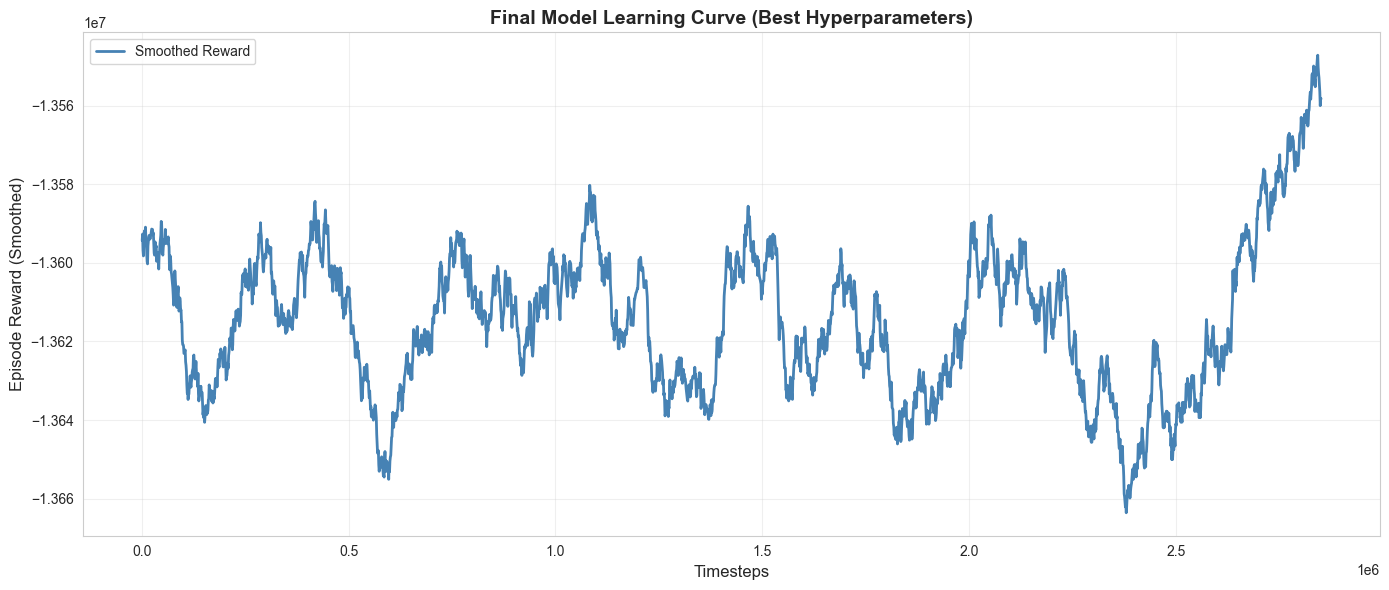

In [8]:
# Train with best hyperparameters for longer
FINAL_TRAINING_TIMESTEPS = 3_000_000  # 3M timesteps for final model

print(f"🚀 Training final model with best hyperparameters")
print(f"   Total timesteps: {FINAL_TRAINING_TIMESTEPS:,}")
print("=" * 80)

# Extract best parameters
best_params = best_trial.params
net_arch = [256, 256] if best_params["net_arch"] == "256x256" else [512, 512]

# Create environment
final_env = InventoryEnvironment(
    k=best_params["k"],
    Q_max=best_params["Q_max"],
    episode_length=1000,
    random_seed=TRAINING_SEED,
)

# Create agent
final_agent = PPOAgent(
    env=final_env,
    learning_rate=best_params["learning_rate"],
    gamma=best_params["gamma"],
    n_steps=best_params["n_steps"],
    batch_size=best_params["batch_size"],
    n_epochs=best_params["n_epochs"],
    clip_range=best_params["clip_range"],
    ent_coef=best_params["ent_coef"],
    gae_lambda=best_params["gae_lambda"],
    policy_kwargs=dict(net_arch=net_arch),
    seed=TRAINING_SEED,
    verbose=0,
)

print(f"✅ Environment: k={best_params['k']}, Q_max={best_params['Q_max']}")
print(f"✅ Agent configured with best hyperparameters")

# Train
print(f"\n⏳ Training for {FINAL_TRAINING_TIMESTEPS:,} timesteps...")
start_time = time.time()

learning_curve_callback = LearningCurveCallback()
final_agent.train(
    total_timesteps=FINAL_TRAINING_TIMESTEPS,
    progress_bar=True,
    callbacks=learning_curve_callback,
)

training_time = time.time() - start_time
print(f"\n✅ Final training complete in {training_time/60:.1f} minutes")

# Save final model
final_model_path = "./models/ppo_final_best"
final_agent.model.save(final_model_path)
print(f"💾 Final model saved: {final_model_path}")

# Plot learning curve
fig, ax = plt.subplots(figsize=(14, 6))
window = max(10, int(0.05 * len(learning_curve_callback.episode_rewards)))
smoothed = np.convolve(
    learning_curve_callback.episode_rewards, 
    np.ones(window)/window, 
    mode='valid'
)
smoothed_steps = learning_curve_callback.episode_timesteps[:len(smoothed)]

ax.plot(smoothed_steps, smoothed, linewidth=2, color='steelblue', label='Smoothed Reward')
ax.set_xlabel("Timesteps", fontsize=12)
ax.set_ylabel("Episode Reward (Smoothed)", fontsize=12)
ax.set_title("Final Model Learning Curve (Best Hyperparameters)", fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Final Model Evaluation

Evaluate the final model on 100 independent test episodes with full diagnostics.

In [9]:
# Use 100 seeds for final evaluation
FINAL_EVAL_SEEDS = generate_seeds(100, start_index=100)
reward_fn = RewardFunction()

print(f"🧪 Evaluating final model on {len(FINAL_EVAL_SEEDS)} episodes...")

final_test_episodes = []

for seed in tqdm(FINAL_EVAL_SEEDS, desc="Final Evaluation"):
    # Create evaluation environment
    eval_env = InventoryEnvironment(
        k=best_params["k"],
        Q_max=best_params["Q_max"],
        episode_length=1000,
        random_seed=seed,
    )
    
    obs, _ = eval_env.reset()
    
    ep_data = {
        "net_inv_0": [],
        "net_inv_1": [],
        "q0": [],
        "q1": [],
        "demand_0": [],
        "demand_1": [],
        "ordering_cost": [],
        "holding_cost": [],
        "shortage_cost": [],
        "total_daily_cost": [],
    }
    
    done = False
    while not done:
        action = final_agent.select_action(obs, deterministic=True)
        action_obj = eval_env.action_space_config.get_action(action)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        
        # Log data
        ep_data["net_inv_0"].append(info["net_inventory"][0])
        ep_data["net_inv_1"].append(info["net_inventory"][1])
        ep_data["q0"].append(action_obj.order_quantities[0])
        ep_data["q1"].append(action_obj.order_quantities[1])
        ep_data["demand_0"].append(info["total_demand"][0])
        ep_data["demand_1"].append(info["total_demand"][1])
        
        state = eval_env.get_current_state()
        costs = reward_fn.calculate_costs(state, action_obj)
        
        ep_data["ordering_cost"].append(costs.ordering_cost)
        ep_data["holding_cost"].append(costs.holding_cost)
        ep_data["shortage_cost"].append(costs.shortage_cost)
        ep_data["total_daily_cost"].append(costs.total_cost)
        
        done = terminated or truncated
    
    final_test_episodes.append(ep_data)

# Calculate statistics
episode_costs = [sum(ep["total_daily_cost"]) for ep in final_test_episodes]
mean_cost = np.mean(episode_costs)
std_cost = np.std(episode_costs)
min_cost = np.min(episode_costs)
max_cost = np.max(episode_costs)

print(f"\n📊 FINAL MODEL PERFORMANCE")
print("=" * 80)
print(f"Mean episode cost: ${mean_cost:.2f} ± ${std_cost:.2f}")
print(f"Min episode cost: ${min_cost:.2f}")
print(f"Max episode cost: ${max_cost:.2f}")
print(f"95% CI: [${mean_cost - 1.96*std_cost/np.sqrt(100):.2f}, ${mean_cost + 1.96*std_cost/np.sqrt(100):.2f}]")

# Cost breakdown
all_ordering = [cost for ep in final_test_episodes for cost in ep["ordering_cost"]]
all_holding = [cost for ep in final_test_episodes for cost in ep["holding_cost"]]
all_shortage = [cost for ep in final_test_episodes for cost in ep["shortage_cost"]]

print(f"\nCost breakdown (average per day):")
print(f"   Ordering: ${np.mean(all_ordering):.2f}")
print(f"   Holding:  ${np.mean(all_holding):.2f}")
print(f"   Shortage: ${np.mean(all_shortage):.2f}")

🧪 Evaluating final model on 100 episodes...


Final Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]


📊 FINAL MODEL PERFORMANCE
Mean episode cost: $7016102.25 ± $197491.70
Min episode cost: $6677881.00
Max episode cost: $7676055.00
95% CI: [$6977393.88, $7054810.62]

Cost breakdown (average per day):
   Ordering: $65.98
   Holding:  $6949.82
   Shortage: $0.30


## 9. Detailed Analysis

Analyze the final model with Welch's procedure and visualizations.

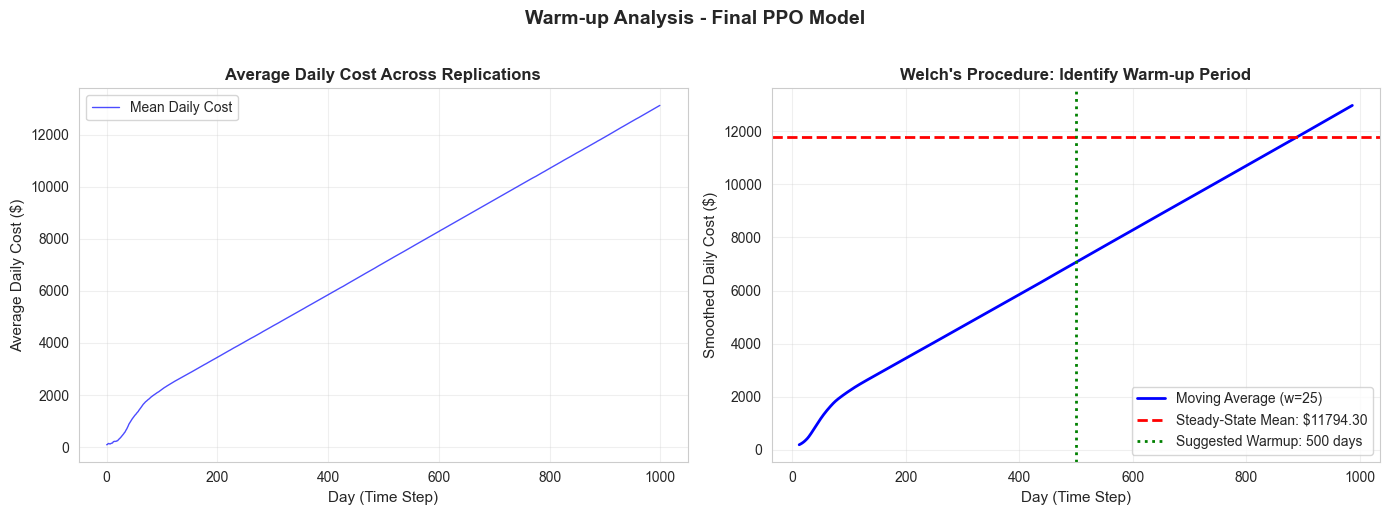

📊 Welch's Procedure Summary:
   Total replications: 100

✅ Suggested Warmup Length: 500 days
   (Detected where curve stays within 5% of steady-state)

💡 Tip: Visually verify the green line on the right plot.
   Adjust manually if needed based on your domain knowledge.
Detected warmup length: 500 days


In [10]:
# Welch's procedure for warmup detection
n_days, n_reps, warmup_length = evaluation_plots.plot_welch_procedure(
    test_episodes=final_test_episodes,
    window_size=25,
    title=f"Warm-up Analysis - Final PPO Model",
)

print(f"Detected warmup length: {warmup_length} days")

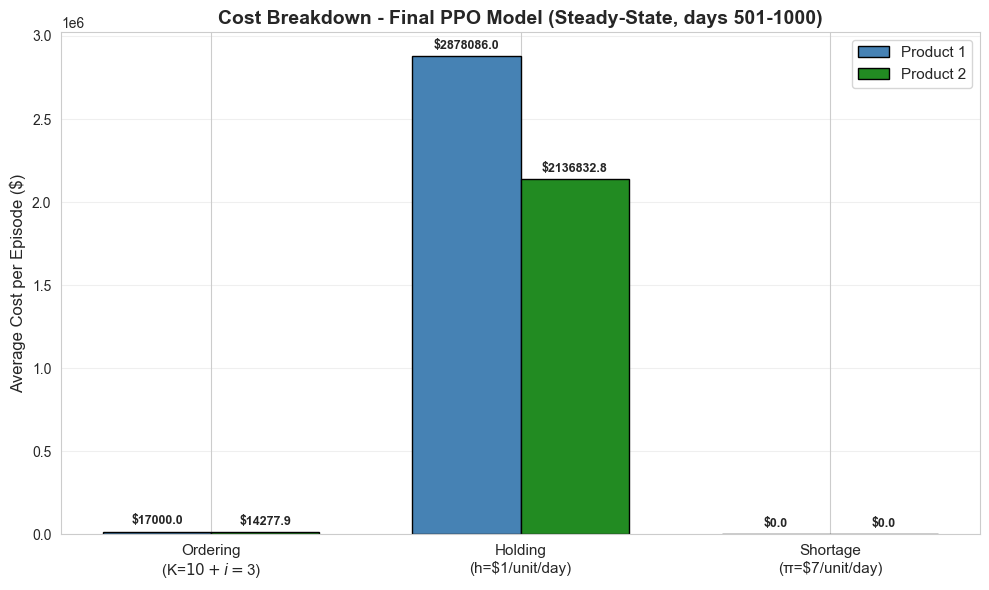

📊 Steady-State Average Cost per Episode (days 501-1000):

  Product 1: $2895085.96
    Ordering: $17000.00 (0.6%)
    Holding:  $2878085.96 (99.4%)
    Shortage: $0.00 (0.0%)

  Product 2: $2151110.61
    Ordering: $14277.86 (0.7%)
    Holding:  $2136832.75 (99.3%)
    Shortage: $0.00 (0.0%)

------------------------------------------------------------

  TOTAL: $5046196.57


In [11]:
# Cost breakdown by product
evaluation_plots.plot_cost_breakdown_by_product(
    test_episodes=final_test_episodes,
    warmup_length=warmup_length,
    n_days=n_days,
    title=f"Cost Breakdown - Final PPO Model",
)

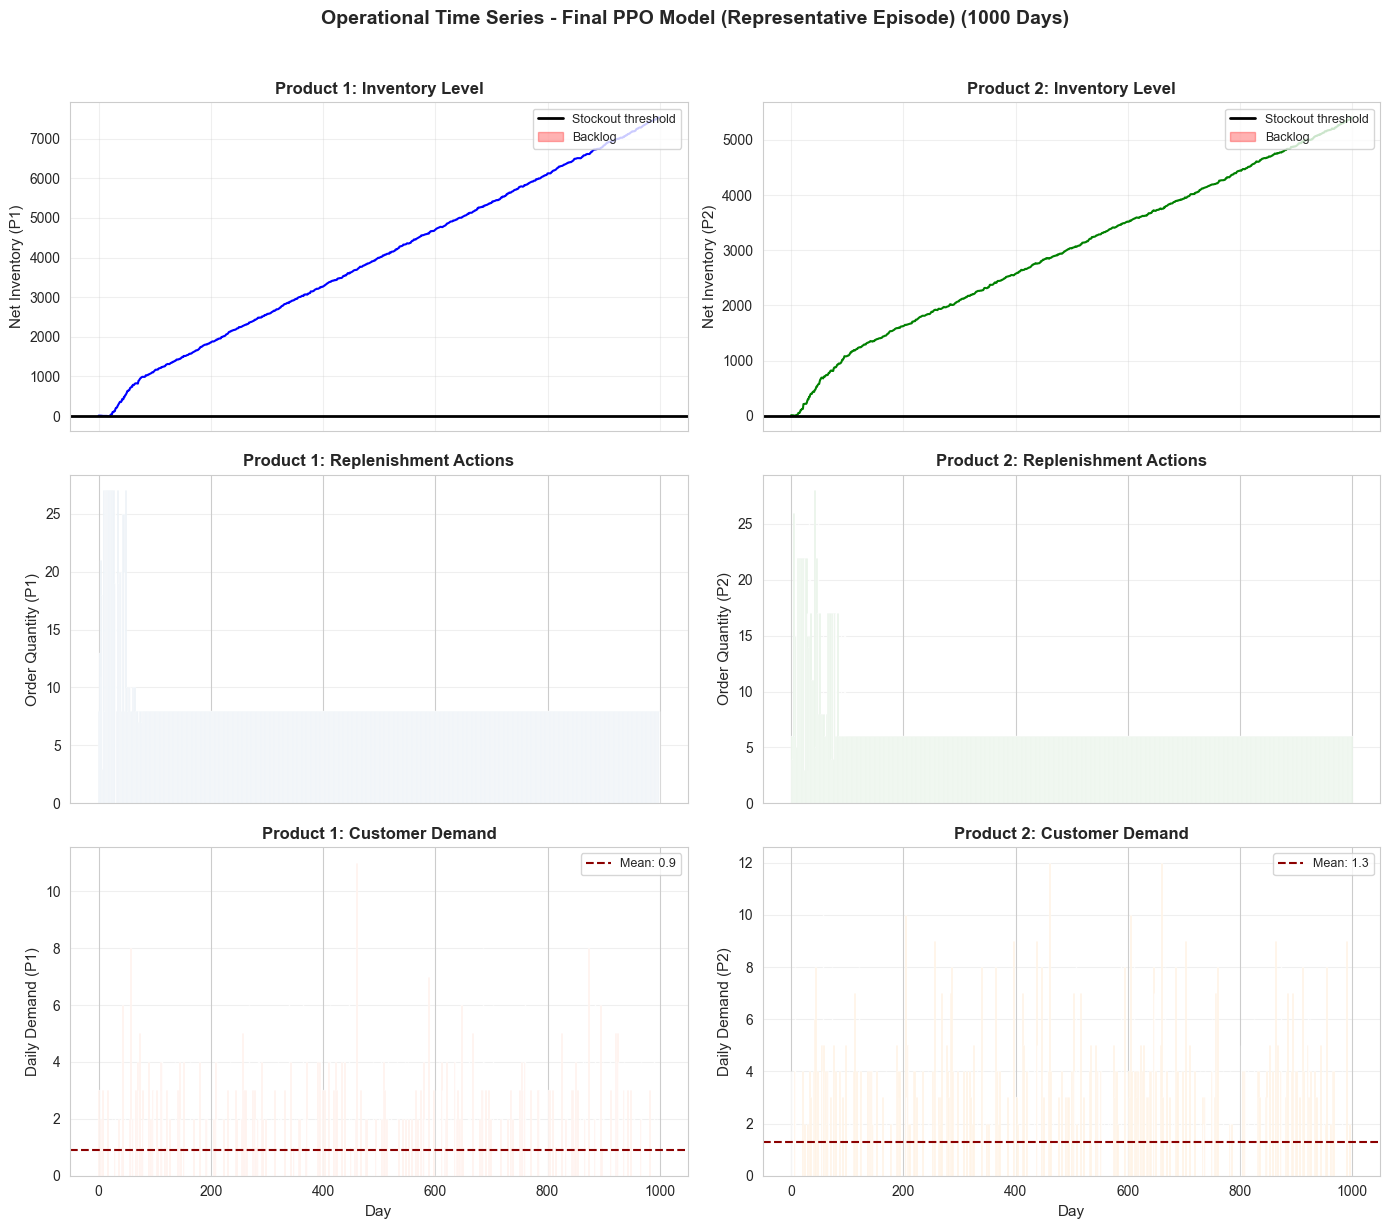

In [12]:
# Operational time series (representative episode)
episode_avg_costs = [np.mean(ep['total_daily_cost']) for ep in final_test_episodes]
global_mean_cost = np.mean(episode_avg_costs)
representative_idx = np.argmin(np.abs(np.array(episode_avg_costs) - global_mean_cost))

evaluation_plots.plot_operational_timeseries(
    episode_data=final_test_episodes[representative_idx],
    title=f"Operational Time Series - Final PPO Model (Representative Episode)",
)

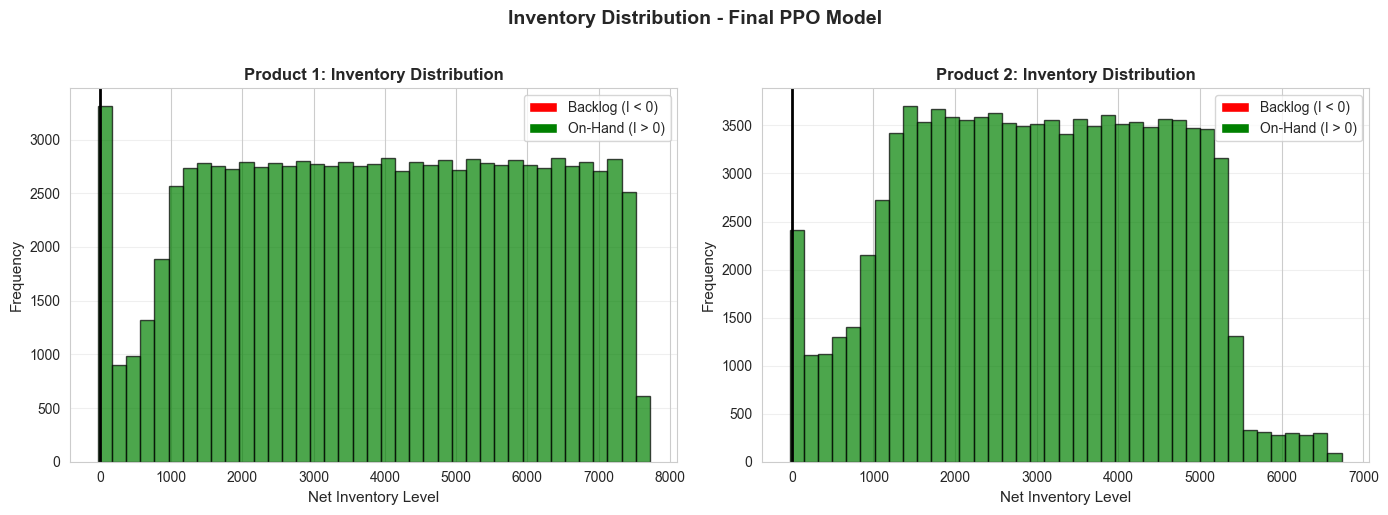

⚙️Service Level (% days without stockout):
  Product 1: 99.4%
  Product 2: 99.8%


In [13]:
# Inventory distribution
evaluation_plots.plot_inventory_histogram(
    test_episodes=final_test_episodes,
    title=f"Inventory Distribution - Final PPO Model",
)

## 10. Save Study Results

Save the complete Optuna study for future reference.

In [ ]:
# Save study to database
study_path = "../results/ppo_optuna_study.db"
Path(study_path).parent.mkdir(parents=True, exist_ok=True)

# Save to SQLite database
import optuna
study_storage = f"sqlite:///{study_path}"
study.study_name = "ppo_inventory_optimization"

print(f"💾 Optuna study saved to: {study_path}")
print(f"   You can reload it with: optuna.load_study(study_name='ppo_inventory_optimization', storage='{study_storage}')")

# Save trials dataframe to CSV
trials_csv_path = "../results/ppo_optuna_trials.csv"
trials_df.to_csv(trials_csv_path, index=False)
print(f"💾 Trials dataframe saved to: {trials_csv_path}")

print("\n" + "=" * 80)
print("✅ OPTIMIZATION COMPLETE")
print("=" * 80)
print(f"\n📊 Summary:")
print(f"   Total trials: {len(study.trials)}")
print(f"   Best trial: #{best_trial.number}")
print(f"   Best cost: ${best_trial.value:.2f}")
print(f"\n📁 Saved files:")
print(f"   - Best config: ./models/config_ppo_best_optuna.json")
print(f"   - Final model: ./models/ppo_final_best.zip")
print(f"   - Study database: {study_path}")
print(f"   - Trials CSV: {trials_csv_path}")